# Predicting sentiment from product reviews


We will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.

First of all, we import library we need.

In [1]:
# Import libraries to use
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import math
import string

## 1. Data preparation

We will use a dataset consisting of baby product reviews on Amazon.com.

In [2]:
# Load the data
datapath = os.path.join("dataset", "")
filename = "amazon_baby.csv"
products = pd.read_csv(datapath + filename)

# Now, let us see a preview of what the dataset looks like.
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [3]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183531 entries, 0 to 183530
Data columns (total 3 columns):
name      183213 non-null object
review    182702 non-null object
rating    183531 non-null int64
dtypes: int64(1), object(2)
memory usage: 4.2+ MB


From above information, it's obvious that there are some missing values in `review` column. Let's fill NaN values in the `review` column with empty strings since the NaN values indicate empty reviews. 

Take a look at some cases with NaN values in the `review` column.

In [4]:
products[products["review"].isnull()].head()

,name,review,rating
38,SoftPlay Twinkle Twinkle Elmo A Bedtime Book,NaN,5
58,Our Baby Girl Memory Book,NaN,5
721,"Summer Infant, Ultimate Training Pad - Twin Ma...",NaN,5
1050,Safety 1st Deluxe 4-in-1 Bath Station,NaN,1
1183,Northstate Superyard Playgate Light Gray,NaN,5


In [5]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [6]:
# Check data types
products.dtypes

name      object
review    object
rating     int64
dtype: object

## 2. Build the word count vector for each review

Let us explore a specific example of a baby product.


In [7]:
products.iloc[269]

name      The First Years Massaging Action Teether
review                    A favorite in our house!
rating                                           5
Name: 269, dtype: object

Now, we will perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Ignore all reviews with rating = 3. And assign reviews with a rating of 4 or higher to be positive reviews (+1), while the ones with rating of 2 or lower are negative (-1).


### Remove punctuation in review

In this notebook, we remove all punctuations for the sake of simplicity. A smarter approach to punctuations would preserve phrases such as "I'd", "would've", "hadn't" and so forth.

**Important**: In original datasets, in `review` there are some missing values. One has to fill missing values by empty string first, and then do following transformation, or those missing values will cause errors.

In [8]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# Remove punctuation in reviews
products['review_clean'] = products['review'].apply(remove_punctuation)
products['review_clean'].iloc[269]

'A favorite in our house'

### Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [9]:
products = products[products['rating'] != 3]
print("After ignoring all reviews with rating = 3, we have {} reviews now.".format(len(products)))

After ignoring all reviews with rating = 3, we have 166752 reviews now.


Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use **+1 for the positive class label** and **-1 for the negative class label**.

In [10]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products.iloc[18:22]

,name,review,rating,review_clean,sentiment
20,Nature's Lullabies Second Year Sticker Calendar,I had a hard time finding a second year calend...,5,I had a hard time finding a second year calend...,1
21,Nature's Lullabies Second Year Sticker Calendar,I only purchased a second-year calendar for my...,2,I only purchased a secondyear calendar for my ...,-1
22,Nature's Lullabies Second Year Sticker Calendar,I LOVE this calendar for recording events of m...,5,I LOVE this calendar for recording events of m...,1
24,Nature's Lullabies Second Year Sticker Calendar,Wife loves this calender. Comes with a lot of ...,5,Wife loves this calender Comes with a lot of s...,1


Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

### Split data into training and test sets

Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [11]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(products['review_clean'], 
                                                    products['sentiment'],
                                                    test_size=0.2,
                                                    random_state=0)

In [12]:
print("Number of reviews in training set is {0} and number of reviews in test set is {1}.".format(len(X_train),len(X_test)))

Number of reviews in training set is 133401 and number of reviews in test set is 33351.


Take a look at number of reviews in training dataset for each classes to see whether it's a imbalanced dataset.

In [13]:
y_train.value_counts()

 1    112270
-1     21131
Name: sentiment, dtype: int64

As we can see from about result, the ratio between positive class and negative class is 5:1. It may cause classifier always to classify the input as major class, say positive class in the current case. This is something important to keep in mind.

Next, we take a look at the test set to see whether the test set has enough points to form a reasonable estimate of generalization error.

In [14]:
y_test.value_counts()

 1    27989
-1     5362
Name: sentiment, dtype: int64

### Build the word count vector for each review

We will now compute the word count for each word that appears in the reviews. A vector consisting of word counts is often referred to as **bag-of-word** features. Since most words occur in only a few reviews, word count vectors are sparse. For this reason, scikit-learn and many other tools use sparse matrices to store a collection of word count vectors. Refer to appropriate manuals to produce sparse word count vectors. General steps for extracting word count vectors are as follows:

- Learn a vocabulary (set of all words) from the training data. Only the words that show up in the training data will be considered for feature extraction.
- Compute the occurrences of the words in each review and collect them into a row vector.
- Build a sparse matrix where each row is the word count vector for the corresponding review. Call this matrix X_train_vectorized.
- Using the same mapping between words and columns, convert the test data into a sparse matrix X_test_vectorized.

The following cell uses [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) in scikit-learn. Notice the token_pattern argument in the constructor. Also, `CountVectorizer` does normalization as a default, `lowercase=True`. That is, **the case has been normalized**, or every term is in lowercase. Hence, words like Skype and SKYPE are counted as the same thing. Case variations are very common that case normalization is usually necessary.

Note that if we do not provide an a-priori dictionary and we do not use an analyzer that does some kind of feature selection, then the number of features will be equal to the vocabulary size found by analyzing the data.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Use this token pattern to keep single-letter words
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', min_df=5)

# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
X_train_vectorized = vectorizer.fit_transform(X_train)

# Second, convert the test data into a sparse matrix, using the same word-column mapping
X_test_vectorized = vectorizer.transform(X_test)

Keep in mind that the test data must be transformed in the same way as the training data.

In [16]:
# Take a look at feature names
print(vectorizer.get_feature_names()[-20:-1])

['zipping', 'zippy', 'zips', 'zipties', 'ziptop', 'zipup', 'zoey', 'zoli', 'zombie', 'zone', 'zones', 'zoo', 'zoom', 'zoomed', 'zooming', 'zooms', 'zooper', 'zoos', 'zulily']


In [17]:
# number of words we found
print(len(vectorizer.get_feature_names()))

20049


It's a sparse matrix with large size!

## 3. Train a sentiment classifier with logistic regression

We will now use **logistic regression** to create a sentiment classifier on the training data. This model will use the sparse word count matrix (`train_matrix`) as an input and the column **sentiment** of `train_data` as the target. 

**Note:** Since our input is a sparse matrix with very large size, it may take few minutes to run.

In [18]:
from sklearn.linear_model import LogisticRegression
sentiment_model = LogisticRegression(max_iter=1000)
sentiment_model.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We got a warning to the effect of "ConvergenceWarning: Liblinear failed to converge, increase the number of iterations." It means that after 100 iterations, the algorithm is failed to improve in the last iteration of the run. One way to improve it is to increase the maximum iterations. After using `max_iter=1000`, the warning is removed. But the more iterations to get convergence, the more time it takes! 

The other difficulty arises as the sentiment model puts too much weight on extremely rare words. One way to rectify this is to apply regularization. Here, we use L2 regularization, the default in `LogisticRegression`. Regularization lessens the effect of extremely rare words. 

## 4. Evaluate the performance on test data

We calculate area under curve (AUC) below to check how well the model we trained can generalize to new dataset.

In [26]:
from sklearn.metrics import roc_auc_score

# Predict the transformed test documents
pred_proba = sentiment_model.predict_proba(X_test_vectorized)[:,1]

print('AUC: ', roc_auc_score(y_test, pred_proba))

AUC:  0.9498234199989235


In [28]:
# get the feature names as numpy array
feature_names = np.array(vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = sentiment_model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['dissapointed' 'worst' 'disappointing' 'worthless' 'useless' 'unusable'
 'intelligent' 'concept' 'tomorrow' 'poorly']

Largest Coefs: 
['outstanding' 'pleasantly' 'minor' 'rich' 'penny' 'excellent' 'relieved'
 'saves' 'entertains' 'amazed']


From above, we can see that those words, dissapointed, worst, disappointing, worthless, useless, concept, poorly, unusable, pointless, and tomorrow, give negative reviews. In contrast, the words, outstanding, pleasantly, excellent, minor, penny, skeptical, rich, worry, awesome, and perfect give posistive reviews.

## 5. Learn another classifier with TFIDF

In "bag of words" approach, it treats every document as a collection of individual words and every word in a document as a potentially important keyword of the document. **However, a term occurring in every document isn't useful for classification but in bag of words approach, this kind of terms will have more counts.** Hence, we introduce new approach to extract features according to bag of words in the following, and it can give more weights for those important terms such that the common terms among documents become less important.

A very popular representation for text is the product of Term Frequency (TF) and Inverse Document Frequency (IDF), commonly referred to as **TFIDF**. The TFIDF value of a term $t$ in a given document $d$ is given by

$$ \text{TFIDF}(t,d) = \text{TF}(t,d) \times \text{IDF}(t), \tag{1}$$

where ${\rm TF}(t,d)$, term counted within the document, is the term frequency (TF) of term $t$ in the document $d$, and ${\rm IDF}(t)$ is the inverse document frequency (IDF) defined as

$$ \text{IDF}(t) = 1 + \log \left( \frac{\text{Total number of documents}}{\text{Number of documents containing } t}\right) = 1 - \log \left( \frac{\text{Number of documents containing } t}{\text{Total number of documents}}\right)$$.

Let's define f as 

$$ {\rm f} = \frac{\text{Number of documents containing } t}{\text{Total number of documents}}$$

so IDF leads to

$$ \text{IDF}(t) = 1- \log {\rm f}(t)$$

and note that $ 0 < {\rm f}(t) \leq 1 $. Let's draw IDF($t$) versus f($t$) in the following:

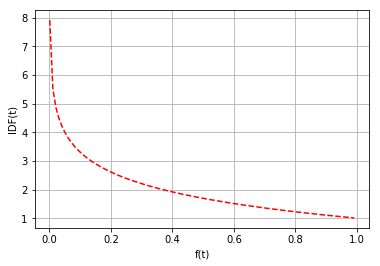

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def idf(t):
    return 1-np.log(t)

t = np.arange(0.001, 1.0, 0.01)
plt.plot(t, idf(t), 'r--')
plt.grid(True)
plt.ylabel("IDF(t)")
plt.xlabel("f(t)")
plt.show()

When ${\rm f}(t) = 1$, it means that the term $t$ occurs in every document so IDF($t$) leads to 1 such that TFIDF in (1) leads to ${\rm TF}(t,d)$. In contrast, a term $t$ happens rarely. For retrieval, a user may be looking for that exact word so it may be important. As we can see in above plot, when item $t$ is rare among every document, f($t$) is close to 0 such that IDF($t$) becomes very large, and TFIDF becomes very large or ${\rm TF}(t,d)$ has much larger weight due to importance. That is, in TFIDF approach, each term has different weight according to its importance. For those common terms among documents, they have weight close to 1; for those rare terms among documents, they have weight much larger than 1. By using this approach, most of stopwords and commom words will become less important since TFIDF is lower than other important terms.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer 
# Convert a collection of raw documents to a matrix of TF-IDF features.

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5   
vect_tfid = TfidfVectorizer(min_df=5).fit(X_train)
len(vect_tfid.get_feature_names())

20013

In [31]:
X_train_vect_tfid = vect_tfid.transform(X_train)

model_tfid = LogisticRegression(max_iter=1000)
model_tfid.fit(X_train_vect_tfid, y_train)

pred_proba_tfid = model_tfid.predict_proba(vect_tfid.transform(X_test))[:,1]

print('AUC: ', roc_auc_score(y_test, pred_proba_tfid))

AUC:  0.9642225134030848


In [32]:
feature_names_tfid = np.array(vect_tfid.get_feature_names())

sorted_tfidf_index = X_train_vect_tfid.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names_tfid[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names_tfid[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['emotionally' 'well3' 'differentthe' 'seatupdate' 'monthspros'
 'paragraph' 'moreupdate' 'suburbs' 'despised' 'use3']

Largest tfidf: 
['beautiful' 'beatiful' 'useful' 'perfect' 'uacutetil' 'excellent'
 'product' 'like' 'nice' 'excelente']


In [33]:
# Sort the coefficients from the model with tfidf
sorted_coef_index_tfidf = model_tfid.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names_tfid[sorted_coef_index_tfidf[:10]]))
print('Largest Coefs: \n{}'.format(feature_names_tfid[sorted_coef_index_tfidf[:-11:-1]]))

Smallest Coefs:
['not' 'disappointed' 'useless' 'returned' 'waste' 'return' 'returning'
 'poor' 'disappointing' 'worst']

Largest Coefs: 
['love' 'great' 'easy' 'perfect' 'loves' 'best' 'perfectly' 'happy'
 'highly' 'glad']


## 6. Recap

We have used logistic regression with L2 regularization to predict sentiment from product review by using two different feature vectorizations: **bag of words** and **TFIDF**. The area under the receiver operating characteristic curve (ROC AUC) on test dataset for these two models are summarized below:

|  bag of words | TFIDF   |
|--------------|----------|
| 0.9498       | 0.9642   |